<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/07.1%20-%20Boulder%20Lefroy%20-%20main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/dem.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
# import the oris and datas
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

In [6]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

# Add final version of the BL fault

In [7]:
BL_pts = gpd.read_file(os.path.join(path_shp, "BL_pts_elevation_2.shp"))
BL_pts = pd.DataFrame({'X': BL_pts.geometry.x, 
              'Y': BL_pts.geometry.y, 
              'Z': BL_pts.DEM_main})

BL_pts['fault_name'] = "Boulder Lefroy Fault"

In [8]:
BL_seismic = gpd.read_file(os.path.join(path_seismic, "Boulder_Lefroy_cropped.shp"))

BL_seismic = BL_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
BL_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

BL_seismic['fault_name'] = BL_seismic['fault_name'].str.replace('Boulder-Lefroy Shear Zone', "Boulder Lefroy Fault")

# drop the values above zero
BL_seismic = BL_seismic.drop(BL_seismic[BL_seismic['Z']>0].index)

In [9]:
# use the seismic to compute the tangents
tangent_xy = (BL_pts[["X", "Y", "Z"]].to_numpy()[0, :] - BL_pts[["X", "Y", "Z"]].to_numpy()[-1, :])
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)

In [10]:
# find the maximum and minimum Z's
max_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()
min_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()

In [11]:
tangent_z1 = (max_xyz - min_xyz)
norm_z = tangent_z1 / np.linalg.norm(tangent_z1) # unit vector

In [12]:
test_CP = np.cross(norm_xy, norm_z)

In [13]:
a = pd.DataFrame(test_CP)
a['fault_name'] = "Boulder Lefroy Fault"
a.columns = ['gx', 'gy', 'gz', 'fault_name']

In [14]:
a['X'] = BL_pts['X'].mean()
a['Y'] = BL_pts['Y'].mean()
a['Z'] = BL_seismic['Z'].mean()

In [15]:
updated_ori = pd.concat([updated_oris, a])

In [16]:
updated_data = pd.concat([updated_data, BL_pts])

In [17]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

# model.nsteps = [100, 100, 200]

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
                           #regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])


#force the tangents over the fault trace points

# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# Force the tangents on BL Fault
tang2 = np.tile(tangent_z1[0],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)


# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])


model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 33                     geological features that need to be interpolated



  0%|          | 0/33 [00:00<?, ?it/s]

Model update took: 114.513827085495 seconds


In [18]:
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault']) 

model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])

model['Zuleika Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])
# model['Boorara Fault'].add_abutting_fault(model['Boulder Lefroy Fault']) ########### This is the wrong one

In [19]:
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])

In [20]:
model['Kunanalling Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])
model['Kunanalling Fault'].add_abutting_fault(model['Boorara Fault'])

In [21]:
model['Bullabulling North Fault'].add_abutting_fault(model['Kanowna Fault'])


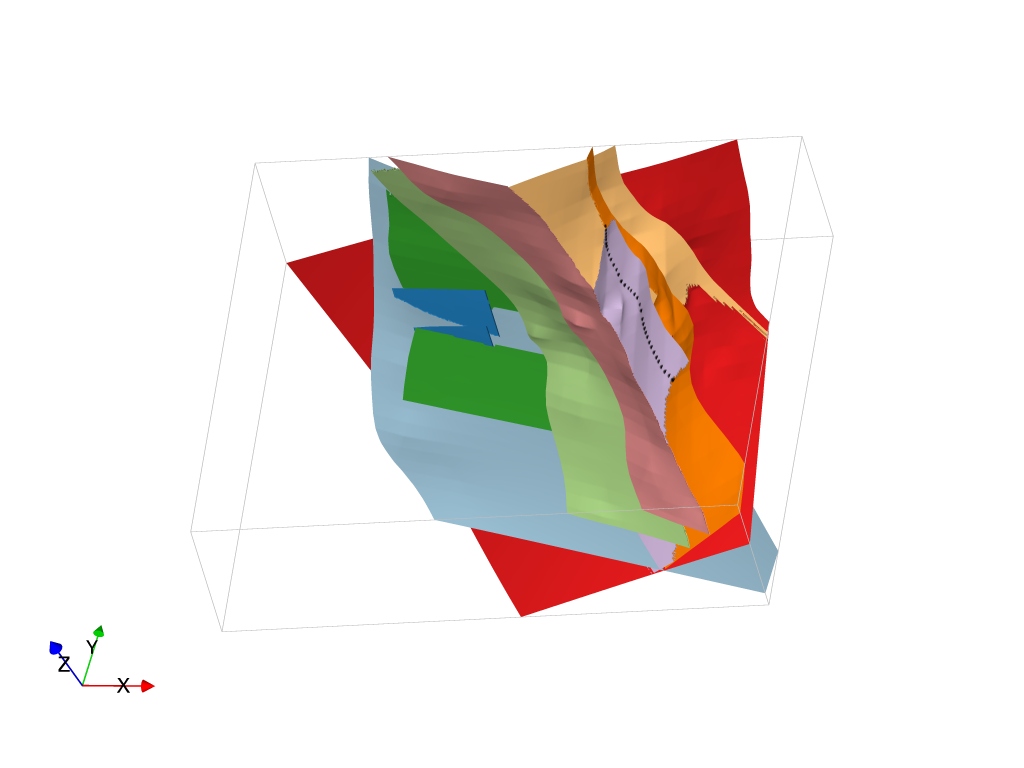

In [22]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)

view.add_points(BL_pts[['X', 'Y', 'Z']], name = 'Boulder_Lefroy_surface', pointsize = 5)

# view.interactive()

view.rotation = [-42.98127365112305, -14.023233413696289, 2.8204379081726074]
view.display()

In [23]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)